In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
import skimage
import IPython.display as disp
from math import floor

In [2]:
DATASET_PATH = "/home/quesneay/mohit/final/dataset_cat/separated/mask/"
# DATASET_PATH = "/home/aymeric/OMA/projet_rech/dataset/mask/"

In [3]:
def display_progress(i, maxi, length):
    disp.display('[' + "".join(
        ['=' for j in range(floor(length*i/maxi))]
    ) + '>' + "".join(
        [' ' for j in range(floor(length*i/maxi)+1, length)]
    ) + ']', str(floor(length*i/maxi)), '%')
    disp.clear_output(wait=True)

In [4]:
from os import listdir

file_list = listdir(DATASET_PATH)
CoMs = {}

In [5]:
from skimage.measure import find_contours, moments
from scipy.ndimage import binary_fill_holes

def find_centers_of_mass(img, thresh=5000):
    contours = find_contours(img, level=0.5)
    centers_of_mass = []
    for i, contour in enumerate(contours):
        int_contour = np.ceil(contour).astype('uint16')
        mat = np.zeros(eroded_image.shape)
        mat[int_contour[:,0], int_contour[:,1]] = 1
        bin_holes = binary_fill_holes(mat)
        m = moments(bin_holes)
        if m[0,0] > thresh:
            x = int(m[0,1]/m[0,0])
            y = int(m[1,0]/m[0,0])
            centers_of_mass.append((x, y))
    return centers_of_mass

In [6]:
from json import dumps, load
from pathlib import Path

if Path("centers_of_mass.json").exists():
    with open("centers_of_mass.json", 'r') as coms_fd:
        CoMs = load(coms_fd)
        print('Loaded centers of mass from file.')
else:
    for i, file in enumerate(file_list):
        img = plt.imread(DATASET_PATH + '/' + file)[:,:,0]
        CoMs[file] = find_centers_of_mass(img)
        display_progress(i, len(file_list), 50)
    with open("centers_of_mass.json", 'w') as fd:
        fd.write(dumps(CoMs))

Loaded centers of mass from file.


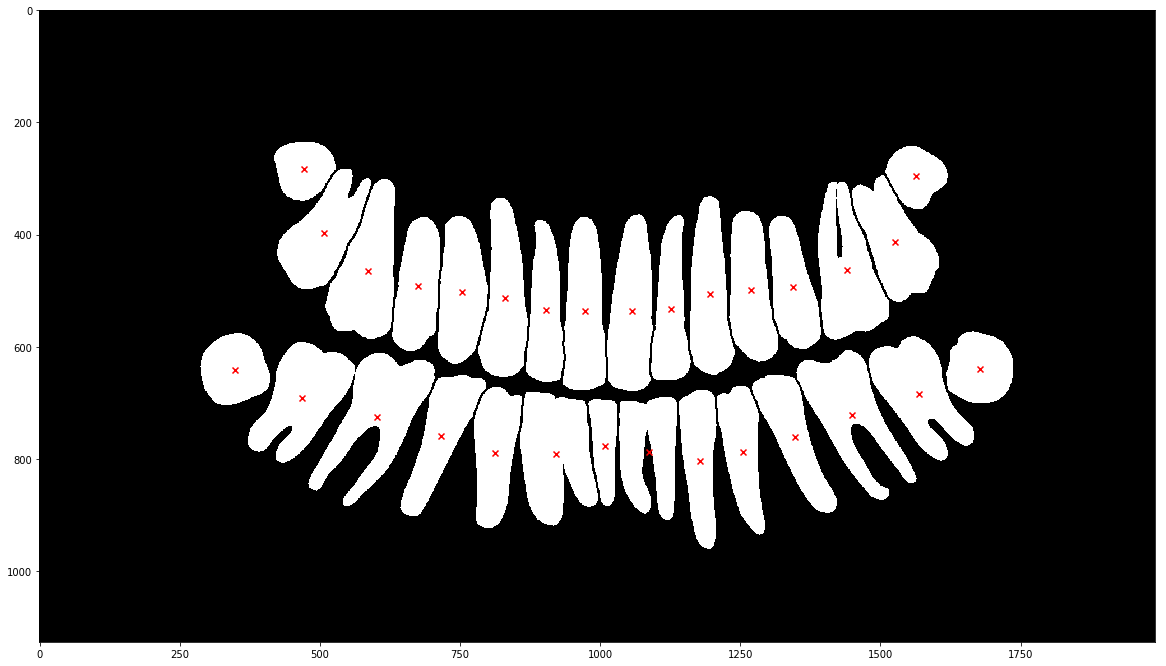

In [7]:
plt.figure(figsize=(20,20))
n_file = 275
file = file_list[n_file]
img = plt.imread(DATASET_PATH + '/' + file)
plt.imshow(img)
centers = np.array(CoMs[file])
plt.scatter(centers[:,0], centers[:,1], marker='x', color='red')

In [8]:
def sort_dentier(dentier):
    # sorts un dentier by finding the nearest neighbor
    N = len(dentier)
    indices = []
    dist = np.sum(np.abs(dentier),axis=1)
    indices.append(np.argmax(dist))
    for i in range(N//2-1):
        s = np.inf
        mini = 0
        for j in range(N):
            norm = np.linalg.norm(dentier[indices[-1]] - dentier[j])
            if norm < s and (j not in indices):
                mini = j
                s = norm
        indices.append(mini)
    dist = np.sum(np.abs(dentier),axis=1)
    indices.append(np.argmin(dist))
    for i in range(N//2+1, N):
        s = np.inf
        mini = 0
        for j in range(N):
            norm = np.linalg.norm(dentier[indices[-1]] - dentier[j])
            if norm < s and (j not in indices):
                mini = j
                s = norm
        indices.append(mini)
    return indices

In [9]:
sorted_centers = sort_dentier(centers)
lower_teeth = centers[sorted_centers[:14]]
upper_teeth = centers[sorted_centers[14:]]

---
## Using quadratic fit

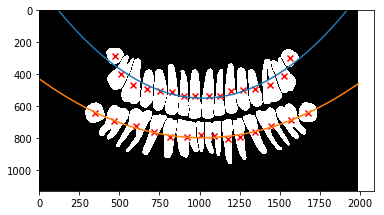

In [10]:
from numpy.polynomial.polynomial import Polynomial
plt.imshow(img)
plt.scatter(centers[:,0], centers[:,1], marker='x', color='red')
xx = np.linspace(0, img.shape[1])
upper_pol = Polynomial.fit(upper_teeth[:,0], upper_teeth[:,1], [0, 1, 2])
yy = upper_pol(xx)
plt.plot(xx, yy)
lower_pol = Polynomial.fit(lower_teeth[:,0], lower_teeth[:,1], [0, 1, 2])
yy = lower_pol(xx)
plt.plot(xx, yy)
plt.gca().set_ylim(img.shape[0], 0);

In [11]:
lower_min = -lower_pol.convert().coef[1]/2/lower_pol.convert().coef[2]
upper_min = -upper_pol.convert().coef[1]/2/upper_pol.convert().coef[2]
x_mean = (lower_min + upper_min)/2
y_gap = upper_min - lower_min

In [12]:
len(centers)

30

In [13]:
lower_pol.convert().coef

array([ 4.28542575e+02,  7.22051243e-01, -3.55121773e-04])

In [14]:
from numpy.polynomial.polynomial import Polynomial

def transform_quad(centers, gap = 1, x_scale = 1):
    # Unfit because some x-rays display no curvature so fitting a quadratic
    # is ill-conditioned
    assert len(centers) == 32
    sorted_centers = sort_dentier(centers)
    lower_teeth = centers[sorted_centers[:16]]
    upper_teeth = centers[sorted_centers[16:]]
    upper_pol = Polynomial.fit(upper_teeth[:,0], upper_teeth[:,1], [0, 2])
    lower_pol = Polynomial.fit(lower_teeth[:,0], lower_teeth[:,1], [0, 2])
    lower_min = -lower_pol.convert().coef[1]/2/lower_pol.convert().coef[2]
    upper_min = -upper_pol.convert().coef[1]/2/upper_pol.convert().coef[2]
    x_mean = (lower_min + upper_min)/2
    y_lower_mean = lower_pol(x_mean)
    y_gap = upper_min - lower_min
    centers = centers - (x_mean, y_lower_mean)
    
    centers[:,1] /= y_gap
    # Normalize horizontally by the order coefficient of the polynomial
    centers[:,0] /= np.sqrt(np.abs(lower_pol.convert().coef[2]))
    
    return centers, (x_mean, y_lower_mean)

In [15]:
_32_teeth = []
not_32_teeth = []
for key in CoMs.keys():
    if len(CoMs[key]) == 32:
        _32_teeth.append(key)
    else:
        not_32_teeth.append(key)

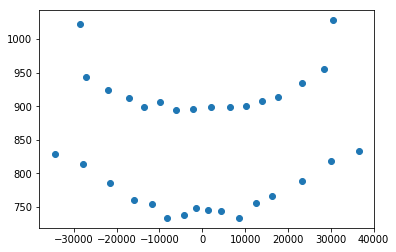

In [16]:
tooth_index = 1
centers = np.array(CoMs[_32_teeth[tooth_index]])
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_index])
transf_centers, shift = transform_quad(centers)
transf_centers += shift
plt.scatter(transf_centers[:,0],transf_centers[:,1])

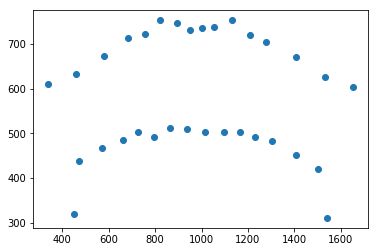

In [17]:
plt.scatter(centers[:,0],centers[:,1])

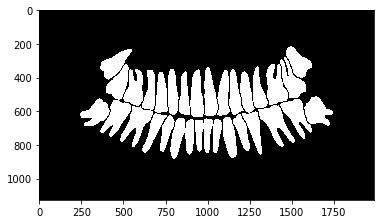

In [18]:
plt.imshow(img)

---
## Robust

In [19]:
from scipy.stats import trim_mean, iqr
def transform_robust(centers):
    centers = centers.astype('float64')
    x_mean = trim_mean(centers[:,0], 0.2)
    x_iqr = iqr(centers[:,0])
    centers[:,0] -= x_mean
    centers[:,0] /= x_iqr
    y_max = np.max(centers[:,1])
    y_min = np.min(centers[:,1])
    centers[:,1] -= y_min
    centers[:,1] /= (y_max - y_min)
    return centers, (x_mean, y_min), (x_iqr, (y_max - y_min))

In [20]:
tooth_index = 2
centers = np.array(CoMs[_32_teeth[tooth_index]])
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_index])

In [21]:
rob_centers, shift, scale = transform_robust(centers)

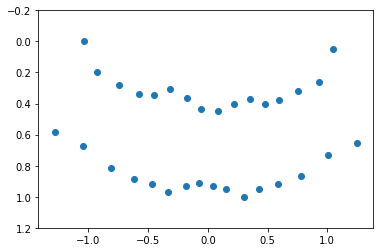

In [22]:
plt.scatter(rob_centers[:,0], rob_centers[:,1])
plt.gca().set_ylim(1.2, -0.2);

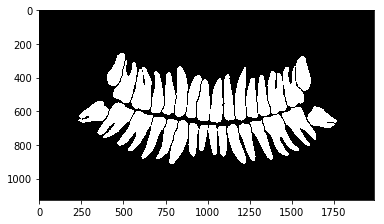

In [23]:
plt.imshow(img)

In [24]:
transformed_centers = []
mean = np.zeros((32,2))
for file in _32_teeth:
    centers = np.array(CoMs[file])
    sorted_centers = centers[sort_dentier(centers)]
    rob_centers, shift, scale = transform_robust(sorted_centers)
    transformed_centers.append(rob_centers)
    mean += rob_centers
mean /= len(_32_teeth)

Text(0.5, 1.0, 'Machoire moyenne')

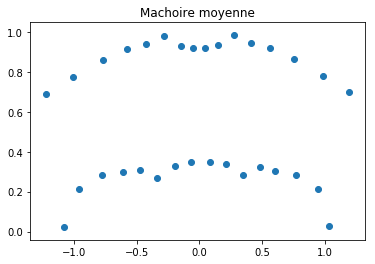

In [25]:
plt.scatter(mean[:,0], mean[:,1])
plt.title("Machoire moyenne")

In [26]:
tooth_ind = 2
img = plt.imread(DATASET_PATH + '/' + not_32_teeth[tooth_ind])
transf, _, _ = transform_robust(np.array(CoMs[not_32_teeth[tooth_ind]]))

Text(0.5, 1.0, 'Comparaison de la machoire moyenne et de la machoire courante')

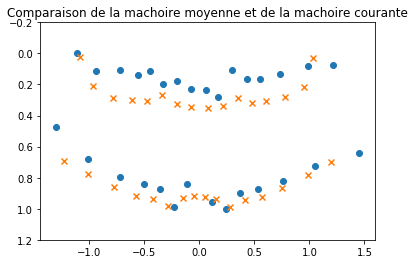

In [27]:
plt.scatter(transf[:,0], transf[:,1])
plt.scatter(mean[:,0], mean[:,1], marker='x')
plt.gca().set_ylim(1.2, -0.2);
plt.title("Comparaison de la machoire moyenne et de la machoire courante")

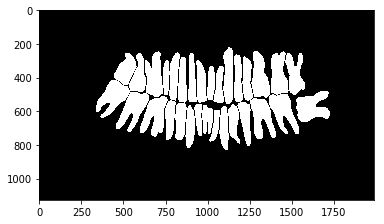

In [28]:
plt.imshow(img)

---
# Basin hopping

In [116]:
from scipy.spatial.distance import cdist

def J(p, R, C, N, nC, lamb, r):
    return (
        lamb*np.sum(np.square(np.linalg.norm(p-R, axis=1)))
        + (1-lamb)*np.sum(np.square(np.clip(cdist(p, C).flatten(), 0, 0.5)))
    )

In [85]:
C = np.array([[-1.5,-0.5],
              [-0.5,-0.5],
              [0.7,-0.2],
              [1.6,0],
              [1.5,0.8],
              [0.4,1.1],
              [-0.5,1.1],
              [-1.5,0.9]])


R = np.array([[-1.5,0],
              [-0.5,0],
              [0.5,0],
              [1.5,0],
              [1.5,1],
              [0.5,1],
              [-0.5,1],
              [-1.5,1]])

In [86]:
D = R + 0.15*np.random.randn(*R.shape)
D = D[:,:]

In [117]:
lamb = 0.5
r = 0.3

J_flat = lambda x: J(x.reshape((len(x)//2, 2)), R, C, len(R), len(C), lamb, r)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(R[:,0], R[:,1], label="référence")
plt.scatter(C[:,0], C[:,1], label="barycentres")
ax = plt.gca()
for i in range(len(C)):
     ax.add_patch(plt.Circle(C[i,:], radius=r, fill=False))
plt.axis('scaled');

plt.scatter(coords[:,0], coords[:,1], marker='x', label="déformation")
plt.legend(fontsize='x-large')

---
## Application

In [123]:
lamb = 0.5
r = 0.10

tooth_ind = 0
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_ind])
transf, _, _ = transform_robust(np.array(CoMs[_32_teeth[tooth_ind]]))

centroids = transf
reference = mean

J_flat = lambda x: J(x.reshape((len(x)//2, 2)), reference, centroids, len(reference), len(centroids), lamb, r)

In [126]:
from scipy.optimize import basinhopping

init_pos = mean.reshape((64,1))

res = basinhopping(J_flat, init_pos, T=0.1, stepsize=0.01, disp=True)
# print(res)

basinhopping step 0: f 110.975
basinhopping step 1: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
found new global minimum on step 1 with function value 110.975
basinhopping step 2: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
found new global minimum on step 2 with function value 110.975
basinhopping step 3: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
basinhopping step 4: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
found new global minimum on step 4 with function value 110.975
basinhopping step 5: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
basinhopping step 6: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
basinhopping step 7: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
basinhopping step 8: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
basinhopping step 9: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
basinhopping step 10: f 110.975 trial_f 110.975 accepted 1  lowest_f 110.975
basinhopping step 1

In [103]:
from scipy.optimize import 

init_pos = mean.reshape((64,1))

res = anneal(J_flat, init_pos, T=20, disp=True)
# print(res)

SyntaxError: invalid syntax (<ipython-input-103-61ff0e3aa9c0>, line 1)

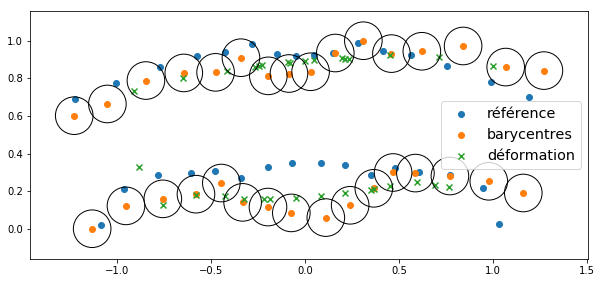

In [127]:
coords = res.x.reshape(reference.shape)
plt.figure(figsize=(10, 6))
plt.scatter(reference[:,0], reference[:,1], label="référence")
plt.scatter(centroids[:,0], centroids[:,1], label="barycentres")
ax = plt.gca()
for i in range(len(centroids)):
     ax.add_patch(plt.Circle(centroids[i,:], radius=r, fill=False))
plt.axis('scaled');

plt.scatter(coords[:,0], coords[:,1], marker='x', label="déformation")
plt.legend(fontsize='x-large')

Mode collapse :'(

---
## Elastic net

In [30]:
from scipy.spatial.distance import cdist

Kij = np.zeros((32,32))
for i in range(1,16):
    Kij[i-1,i] = 1 # Upper jaw
    Kij[16+i-1,16+i] = 1 # Lower jaw
for i in range(Kij.shape[0]//2):
    Kij[i,31-i] = 1
L = cdist(mean, mean)

def K(P, Kij, L, C, lamb=0.5, d_clip=np.inf):
    # Assume R is sorted
    return (
        lamb*np.sum(np.multiply(Kij, np.square(cdist(P, P) - L)))
        + (1-lamb)*np.sum(np.square(np.clip(cdist(P, C).flatten(), 0, d_clip)))
    )

In [46]:
lamb = 0.9
r = 0.05

tooth_ind = 1
img = plt.imread(DATASET_PATH + '/' + _32_teeth[tooth_ind])
transf, _, _ = transform_robust(np.array(CoMs[_32_teeth[tooth_ind]]))

centroids = transf
reference = mean

K_flat = lambda x: K(x.reshape((len(x)//2, 2)), Kij, L, centroids, lamb=0.5, d_clip=0.25)

In [47]:
from scipy.optimize import basinhopping, minimize

init_pos = mean.reshape((64,1))

res = minimize(K_flat, init_pos, method='BFGS')
# res = basinhopping(K_flat, init_pos, T=0.1, stepsize=0.01, disp=True)
# print(res)

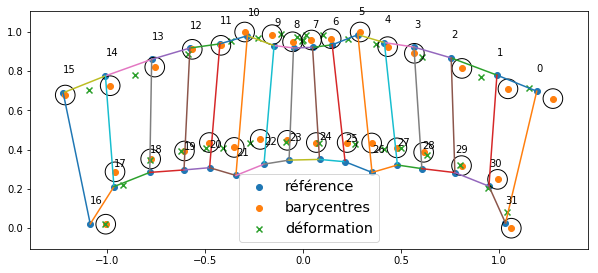

In [48]:
coords = res.x.reshape(reference.shape)
plt.figure(figsize=(10, 6))
plt.scatter(reference[:,0], reference[:,1], label="référence")
plt.scatter(centroids[:,0], centroids[:,1], label="barycentres")
for i in range(len(reference)):
    plt.text(reference[i,0], reference[i,1]+0.1, str(i))
for i in range(Kij.shape[0]):
    for j in range(Kij.shape[1]):
        if Kij[i,j] == 1:
            plt.plot([reference[i,0], reference[j,0]], [reference[i,1], reference[j,1]], '-')
ax = plt.gca()
for i in range(len(centroids)):
     ax.add_patch(plt.Circle(centroids[i,:], radius=r, fill=False))
plt.axis('scaled');

plt.scatter(coords[:,0], coords[:,1], marker='x', label="déformation")
plt.legend(fontsize='x-large')

In [159]:
res.x

array([-2.14273424e-03,  5.10510926e-01,  1.73020009e-02,  5.11127285e-01,
       -8.37089611e-03,  5.10313945e-01,  1.37813884e-02,  5.11015632e-01,
       -4.01184271e-03,  5.10451923e-01,  1.19278795e-02,  5.10957002e-01,
       -2.62286319e-03,  5.10495814e-01,  9.55944680e-03,  5.10882153e-01,
       -1.33500595e-03,  5.10536566e-01,  1.08918320e-02,  5.10924253e-01,
       -4.01689583e-03,  5.10451897e-01,  1.23908206e-02,  5.10971210e-01,
       -5.80297801e-03,  5.10395638e-01,  1.67333699e-02,  5.11108655e-01,
       -9.51986490e-03,  5.10278514e-01,  1.07043734e-02,  5.10917612e-01,
       -6.20198291e-05,  5.15667750e-01,  1.17354365e-02,  5.01582634e-01,
       -2.53591354e-03,  5.18621411e-01,  9.53843781e-03,  5.04206099e-01,
       -7.08640680e-04,  5.16439398e-01,  9.35776612e-03,  5.04422716e-01,
       -9.62276724e-04,  5.16741279e-01,  9.16836553e-03,  5.04648966e-01,
       -1.01616790e-03,  5.16805679e-01,  9.05690082e-03,  5.04781732e-01,
       -9.62474566e-04,  

In [ ]:
plt.figure(figsize=(30*img_ratio,30))
plt.imshow(img)
for key in PoI.keys():
    plt.scatter(PoI[key][0], PoI[key][1], c='yellow', marker='x')
    plt.text(PoI[key][0], PoI[key][1]+50, key, color='yellow')

---
## Illustration mode "surfing"

In [38]:
xx = np.linspace(0, 20, 200)
threes = 2*np.ones((200, 2))
threes[:,1] = 0.25*np.square(xx-4)
yy1 = np.min(threes, axis=1)
threes = 2*np.ones((200, 2))
threes[:,1] = 0.25*np.square(xx-8)
yy2 = np.min(threes, axis=1)
yyt = yy1 + yy2
yy_sol = np.min(np.concatenate((yy1.reshape((200,1)), yy2.reshape((200,1))), axis=1), axis=1)-0.1

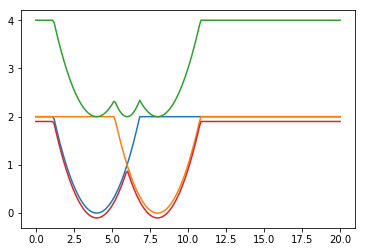

In [39]:
plt.plot(xx, yy1)
plt.plot(xx, yy2)
plt.plot(xx, yyt)
plt.plot(xx, yy_sol)

In [33]:
np.concatenate((yy1.reshape((200,1)), yy2.reshape((200,1))), axis=1).shape

(200, 2)

In [30]:
np.info(np.concatenate)

 concatenate(*args, **kwargs)

concatenate((a1, a2, ...), axis=0, out=None)

Join a sequence of arrays along an existing axis.

Parameters
----------
a1, a2, ... : sequence of array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int, optional
    The axis along which the arrays will be joined.  If axis is None,
    arrays are flattened before use.  Default is 0.
out : ndarray, optional
    If provided, the destination to place the result. The shape must be
    correct, matching that of what concatenate would have returned if no
    out argument were specified.

Returns
-------
res : ndarray
    The concatenated array.

See Also
--------
ma.concatenate : Concatenate function that preserves input masks.
array_split : Split an array into multiple sub-arrays of equal or
              near-equal size.
split : Split array into a list of multiple sub-arrays of equal size.
hsplit : Split array into multiple sub-